# Timings

This assignment is meant to be run on **four nodes** with 28 cores.

One thing we are trying to do is gauge the performance of a good MPI implementation and compare it to a good OpenMP implementation.  In order to do this, we will have to load some slightly different modules.

In [2]:
module unload cse6230
module load cse6230/gcc-omp-gpu
module list

|                                                                         |
|       A note about python/3.6:                                          |
|       PACE is lacking the staff to install all of the python 3          |
|       modules, but we do maintain an anaconda distribution for          |
|       both python 2 and python 3. As conda significantly reduces        |
|       the overhead with package management, we would much prefer        |
|       to maintain python 3 through anaconda.                            |
|                                                                         |
|       All pace installed modules are visible via the module avail       |
|       command.                                                          |
|                                                                         |
Currently Loaded Modulefiles:
  1) curl/7.42.1
  2) git/2.13.4
  3) python/3.6
  4) /nv/coc-ice/tisaac3/opt/pace-ice/modulefiles/jupyter/1.0
  5) cuda/9.1
  6) /nv/

([mvapich](http://mvapich.cse.ohio-state.edu/) is a fork of the [mpich](https://www.mpich.org/) MPI implementation with some modifications for performance on various HPC hardware)

## Measuring MPI primitives

**Task 1 (3 pts)** The file `benchmarks.c` includes some basic benchmarks for measuring the performance of various MPI point-to-point and collective operations.  Right now, it is incomplete!

In [3]:
grep "TODO" benchmarks.c

  /* TODO: split the communicator `comm` into one communicator for ranks
  /* TODO: destroy the subcommunicator created in `splitCommunicator` */
  /* TODO: Record the MPI walltime in `tic_p` */
  /* TODO: Get the elapsed MPI walltime since `tic_in`,
  /* TODO: take the times from all processes and compute the maximum,
      /* TODO: Set up a ping pong test for the broadcast collective.  When
      /* TODO: Set up a ping pong test for the scatter collective.  When
      /* TODO: Set up a timing loop for the following:
      /* TODO: Set up a timing loop for the following:
      /* TODO: Set up a timing loop for the following:


Refering to a good [MPI Tutorial](https://computing.llnl.gov/tutorials/mpi/) or
[lecture notes](http://vuduc.org/cse6230/slides/cse6230-fa14--06-mpi.pdf) as needed,
fill in the missing MPI routines.

Once you have done that, run the following script to generate a graph of benchmark bandwidths of MPI routines.  Note that these values are only for MPI messages within a node: values may be different when we start using multiple nodes. 

In [5]:
make runbenchmarks

mpicc -fopenmp -I../../utils -g -Wall -O3 -std=c99 -c -o benchmarks.o benchmarks.c
mpicc -fopenmp -o benchmarks benchmarks.o 
mpirun -f /var/spool/torque/aux//109660.ice-sched.pace.gatech.edu -n 28 ./benchmarks | xvfb-run python figgen.py
('Send', [8, 64, 512, 4096, 32768, 262144, 2097152], [97390300.0, 1579030000.0, 7841620000.0, 23894100000.0, 38443700000.0, 47998500000.0, 42912500000.0])
('Bcast', [8, 64, 512, 4096, 32768, 262144, 2097152], [inf, inf, inf, inf, inf, inf, inf])
('Scatter', [8, 64, 512, 4096, 32768], [inf, inf, inf, inf, inf])
('Allreduce', [8, 64, 512, 4096, 32768, 262144, 2097152], [inf, inf, inf, inf, inf, inf, inf])
('Allgather', [8, 64, 512, 4096, 32768], [inf, inf, inf, inf, inf])
('Alltoall', [8, 64, 512, 4096, 32768], [inf, inf, inf, inf, inf])


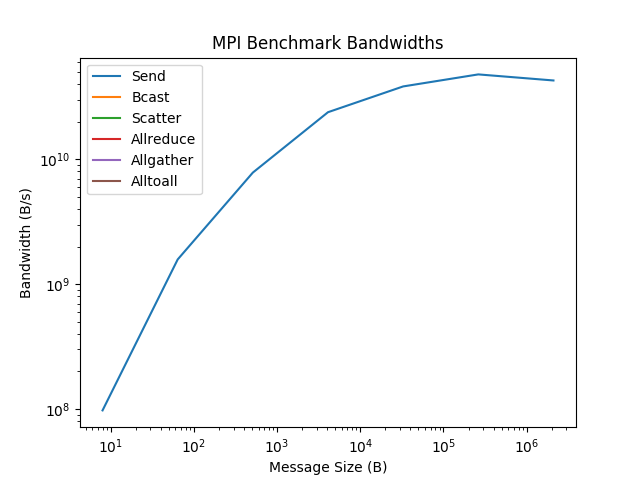

In [6]:
display < benchmarks.png

(Right now the graph is showing no values because the "timing" values are negative until you complete the code)

**Task 2 (2 pts)** We've talked in class about a simplified model of the cost of an MPI message: $\lambda + g b$, where $\lambda$ is the latency and $g$ is the inverse bandwidth.
Using your graph for Send/Recv bandwidths for different message sizes (which was simply calculated from dividing the message size by the message time), estimate $\lambda$ (units secs) and $g$ (units secs/byte) for this MPI implementation on these nodes.

**Task 4 (3 pts)** The point-to-point sends and receives in MPI are _symmetric_: there must be a receive for each send.  What if we start with a list of messages that is _asymmetric_: we know who to send to, but not who to receive from.

Suppose rank $i$ has $N_i$ messages bound for receivers $r_{i,j}$ for $1 \leq j \leq N_i$.  Let $S_{i,j}$ be the size of the message from $i$ to $r_{i,j}$, and let $S_i = \sum_j S_{i,j}$ be the total outgoing message volume from rank $i$.

Process $r_{i,j}$ does not know it is going to receive a message from $i$.

Give pseudocode below for two algorithms, using MPI sends, receives, and collectives that we have talked about, to send all of the messages.

In the first one, assume that there is a large volume of communication: that $S_i \in O(P)$ for each $i$.

In the second one, assume that there is a small volume of communication, and a small number of communicators:
$S_i \in O(1)$, and each rank needs to send or receive a message from $O(1)$ other processes.